# Рекомендация тарифов

# Тех задание от клиента:

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

В ходе проекта проведён исследовательский анализ данных, использованы t-тесты для выявления значимых зависимостей. Построены модели предсказания тарифов: дерево решений, случайный лес, логистическая регрессия. В качестве метрики использован accuracy. Результаты сравнили со случайной классификацией.

Использованы библиотеки pandas, matplotlib, scipy, sklearn.

## Изучаем базу данных

Импортируем модули, которые нам понадобятся для дальнейшей работы.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as st
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn import tree
from sklearn.dummy import DummyClassifier

Читаем базу данных.

In [2]:
df = pd.read_csv('users_behavior.csv', sep= ',')
display(df)
df.info()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


В предоставленной базе данных всего 5 столбцов, 4 из которых - переменные-предикторы:
- количество звонков в месяц
- длительность звонков в месяц
- количество сообщений
- интернет-трафик в мегабайтах

По этим практикам потребления мобильной связи необходимо предсказать пятую переменную - тариф. Это столбец "is_ultra", где 1 - объект подключён к тарифу "Ультра". В противном случае это тариф "Смарт".
Столбцы таблицы названы корректно, пропусков нет. Ранее мы получали информацию о том, что оператор связи округляет в большую сторону минуты и интернет-трафик, на данном этапе будем считать эту информацию несущественной.

Посмотрим на распределения, нет ли выбросов и сколько у нас пользователей тарифа "Ультра", достаточно ли данных для предсказания.

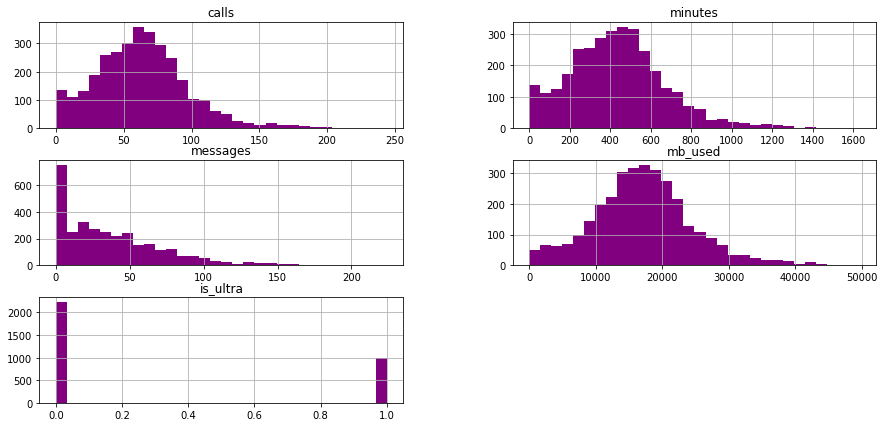

In [3]:
df.hist(
    bins = 30,
    color = 'purple',
    figsize = (15,7))
plt.show()

Основные переменные, по которым мы будем предсказывать 

У нас около тысячи "полезных" записей, поэтому мы можем в дальнейшем разделить данные и на 2, и на 3 выборки, однако лучше применить стратифицированный отбор, чтобы зафиксировать долю пользователей "Ультра" в каждой подвыборке. Прочие переменные очищены от выбросов, кроме "messages". Здесь очень большая доля тех, кто не пользовался сообщениями вообще. Обратим на это внимание, но пока действовать не будем.

## Разбивка данных на выборки

Посмотрим на связь предикторов с целевым признаком. Все ли они влияют на тариф, к которому подключён объект?

In [4]:
alpha = 0.05
for _ in df.drop(['is_ultra'], axis=1).columns:
    a_data = df.loc[df['is_ultra'] == 1, _]
    b_data = df.loc[df['is_ultra'] == 0, _]
    p_value = st.ttest_ind(a_data, b_data, equal_var=False).pvalue
    
    print(p_value)
    if p_value > alpha:
        print(f'Между группами по тарифам в {_} нет значимых отличий')
    else:
        print(f'Между группами по тарифам в {_} ЕСТЬ значимые отличия')

1.884480185046945e-22
Между группами по тарифам в calls ЕСТЬ значимые отличия
1.3446735422636459e-22
Между группами по тарифам в minutes ЕСТЬ значимые отличия
8.729206603931645e-22
Между группами по тарифам в messages ЕСТЬ значимые отличия
1.397720425700292e-20
Между группами по тарифам в mb_used ЕСТЬ значимые отличия


Похоже, что связь между переменными есть. Посмотрим на логику связи переменных друг с другом, построив корреляционную матрицу:

In [5]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Меньше всего логики прослеживается между связью количества использованных сообщений и выбранным тарифом. Помним, что существенный массив данных признака "messages" составляют нули. Если заменить нули на пропуски, то коэффициенты корреляции будут изменяться не от -1 до +1, а инструменты класификационного анализа не смогу работать с пропущенными данными. Если заменить нули на пропуски, коэффициенты корреляции будут выше, но корреляция количества сообщений с прочими признаками всё равно останется самой слабой:

In [6]:
df[df['messages'] != 0].corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982508,0.212918,0.279052,0.208452
minutes,0.982508,1.000000,0.208242,0.271113,0.206527
messages,0.212918,0.208242,1.000000,0.256056,0.291378
mb_used,0.279052,0.271113,0.256056,1.000000,0.194989
is_ultra,0.208452,0.206527,0.291378,0.194989,1.000000


Заходя в эксперименте дальше, мы увидели, что качество моделей только улучшается при исключении признака количества сообщений из анализа, поэтому в дальнейшем удалим этот признак из предикторов.

Также мы видим, что, крайне высокая корреляция между признаками числа звонков и суммарной длительностью. Построим диаграммы рассеяния, чтобы убедиться в связи:

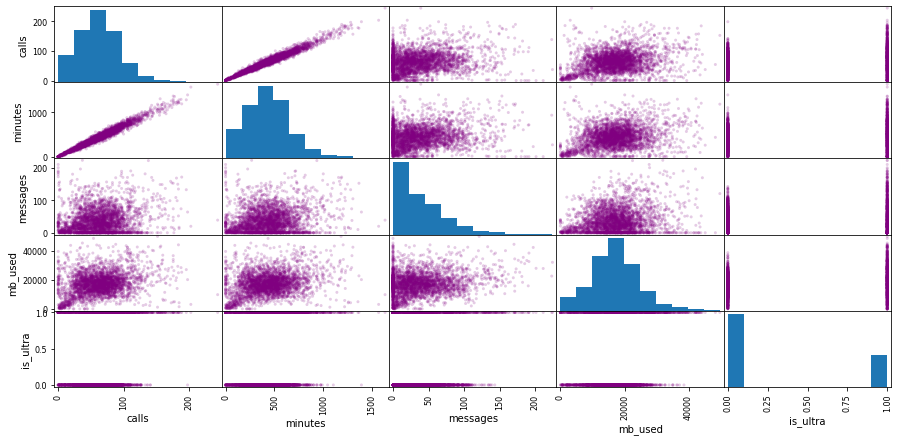

In [7]:
pd.plotting.scatter_matrix(
    df,
    alpha=0.2,
    color = 'purple',
    figsize = (15,7))
plt.show()

Похоже, что количество звонков и длительность звонков в минутах - есть по сути один фактор. Удалим количество звонков, оставив количество минут. Сделаем это на основании правила о независимости переменных, входящих в регрессионный анализ здесь: http://www.fa.ru/fil/orel/science/nir/Documents/Filonova_st9.pdf

Извлечём признаки потраченных мегабайт и длительности совершённых звонков из базы и сохраним их в X - набор данных, на которых будет строиться прогноз.

Извлечём целевой признак (тариф) и сохраним его в y. Это то, что мы будем предсказывать.

Т.к. у нас нет как таковой тестовой выборки, мы должны и научиться, и протестировать полученную модель на одном наборе данных. Поэтому мы отделим тестовую выборку от основного массива данных и на этапе поиска модели не будем её касаться. Также нам понадобится валидационная выборка, которая будет играть роль тестовой на этапе обучения и поиска модели.

Определим долю основной выборки как 60%, чтобы больше данных осталось для обучения модели. Добавим параметр стратификации выборки, чтобы улучшить её качество и репрезентативность. Укажем параметр random_state, чтобы результат был стабилен при повторном запуске кода. Перемешивать данные при отборе не будем, т.к. выше, когда мы отображали таблицу, мы видели, что данные неупорядочены.

In [8]:
X = df.drop(['is_ultra','messages','calls'], axis=1)
y = df['is_ultra']

X_train, X_to_split, y_train, y_to_split = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=12345)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_to_split, y_to_split, test_size=0.5, stratify=y_to_split, random_state=12345)

print(X.shape, y.shape)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(3214, 2) (3214,)
(1928, 2) (1928,)
(643, 2) (643,)
(643, 2) (643,)


## Исследование моделей

Наша задача - предсказать дихотомическую переменную (0 или 1), это задача классификации. Для этого из изученных моделей нам подойдёт:
- Дерево решений (структура данных DecisionTreeClassifier)
- Случайный лес (структура данных RandomForestClassifier)
- Логистическая регрессия (структура данных LogisticRegression)

Меняя параметры, найдём лучшие для каждой модели, затем выберём из трёх лучшую.

### Дерево решений

Построим дерево решений и визуализируем его. Глубину выберем 4 для лучшего визуального отображения.

accuracy: 0.7744945567651633


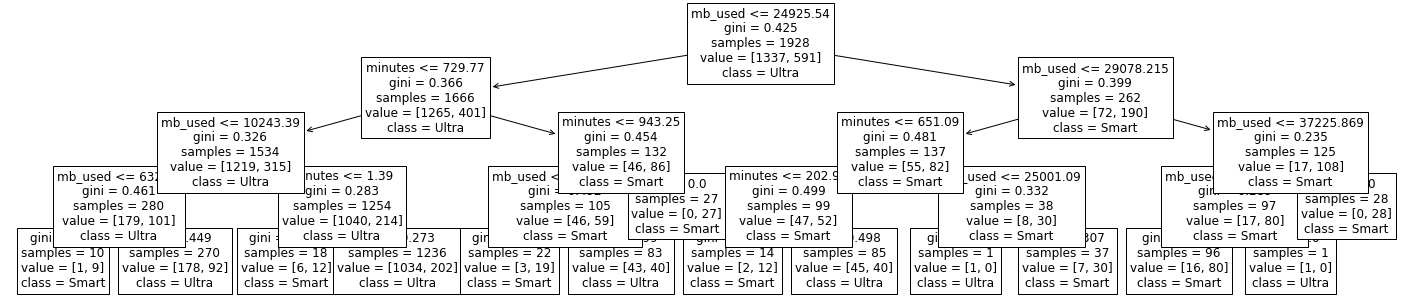

In [9]:
model = DecisionTreeClassifier(max_depth=4, random_state=12345)
model.fit(X_train, y_train)
predictions_valid = model.predict(X_valid)
print('accuracy:', accuracy_score(y_valid, predictions_valid))
plt.figure(figsize=(25, 5))
tree.plot_tree(model, feature_names=X.columns, class_names = ['Ultra', 'Smart'], fontsize=12)
plt.show()

Мы немного поменяли параметры вручную и обнаружили, что первым узлом всегда стоит использование более 25 Гб интернета в месяц, что сразу классифицирует объект как пользователя тарифа Ультра.
В задании требуется добиться accuracy более 0,75. Найдём лучшие параметры для простого дерева решений. Глубина:

In [10]:
for depth in range(1, 21):
    model = DecisionTreeClassifier(random_state=12345, max_depth = depth)

    model.fit(X_train, y_train)

    predictions_valid = model.predict(X_valid)

    print("max_depth =", depth, ": ", end='')
    print(accuracy_score(y_valid, predictions_valid)) 

max_depth = 1 : 0.7402799377916018
max_depth = 2 : 0.7822706065318819
max_depth = 3 : 0.7822706065318819
max_depth = 4 : 0.7744945567651633
max_depth = 5 : 0.7884914463452566
max_depth = 6 : 0.7900466562986003
max_depth = 7 : 0.7853810264385692
max_depth = 8 : 0.7589424572317263
max_depth = 9 : 0.7620528771384136
max_depth = 10 : 0.7511664074650077
max_depth = 11 : 0.7527216174183515
max_depth = 12 : 0.7340590979782271
max_depth = 13 : 0.7247278382581649
max_depth = 14 : 0.71850699844479
max_depth = 15 : 0.7076205287713841
max_depth = 16 : 0.6998444790046656
max_depth = 17 : 0.7013996889580093
max_depth = 18 : 0.7045101088646968
max_depth = 19 : 0.6998444790046656
max_depth = 20 : 0.702954898911353


После десятого шага качество модели ухудшается. Лучший результат - на "глубине" дерева 8 или 9. Теперь подберём минимальную выборку для разделения:

In [11]:
for min_split in range(2, 201):
    model = DecisionTreeClassifier(random_state=12345, max_depth = 8, min_samples_split = min_split)

    model.fit(X_train, y_train)

    predictions_valid = model.predict(X_valid)

    print("min_split =", min_split, ": ", end='')
    print(accuracy_score(y_valid, predictions_valid)) 

min_split = 2 : 0.7589424572317263
min_split = 3 : 0.7573872472783826
min_split = 4 : 0.7573872472783826
min_split = 5 : 0.7558320373250389
min_split = 6 : 0.7573872472783826
min_split = 7 : 0.7558320373250389
min_split = 8 : 0.7573872472783826
min_split = 9 : 0.7558320373250389
min_split = 10 : 0.7573872472783826
min_split = 11 : 0.7573872472783826
min_split = 12 : 0.7620528771384136
min_split = 13 : 0.7636080870917574
min_split = 14 : 0.7636080870917574
min_split = 15 : 0.7636080870917574
min_split = 16 : 0.7636080870917574
min_split = 17 : 0.7713841368584758
min_split = 18 : 0.7713841368584758
min_split = 19 : 0.7713841368584758
min_split = 20 : 0.7713841368584758
min_split = 21 : 0.7713841368584758
min_split = 22 : 0.7713841368584758
min_split = 23 : 0.7713841368584758
min_split = 24 : 0.7713841368584758
min_split = 25 : 0.7744945567651633
min_split = 26 : 0.7744945567651633
min_split = 27 : 0.7744945567651633
min_split = 28 : 0.7744945567651633
min_split = 29 : 0.7744945567651633


Здесь качество модели наивысшее при минимальной выборке для разделения в 106 объектов. Подберём минимальную выборку на конечных "листах":

In [12]:
for min_leaf in range(1, 201):
    model = DecisionTreeClassifier(random_state=12345, max_depth = 8, min_samples_split = 106, min_samples_leaf = min_leaf)

    model.fit(X_train, y_train)

    predictions_valid = model.predict(X_valid)

    print("min_leaf =", min_leaf, ": ", end='')
    print(accuracy_score(y_valid, predictions_valid)) 

min_leaf = 1 : 0.7884914463452566
min_leaf = 2 : 0.7884914463452566
min_leaf = 3 : 0.7884914463452566
min_leaf = 4 : 0.7900466562986003
min_leaf = 5 : 0.7900466562986003
min_leaf = 6 : 0.7916018662519441
min_leaf = 7 : 0.7916018662519441
min_leaf = 8 : 0.7916018662519441
min_leaf = 9 : 0.7916018662519441
min_leaf = 10 : 0.7916018662519441
min_leaf = 11 : 0.7916018662519441
min_leaf = 12 : 0.7900466562986003
min_leaf = 13 : 0.7900466562986003
min_leaf = 14 : 0.7931570762052877
min_leaf = 15 : 0.7931570762052877
min_leaf = 16 : 0.7931570762052877
min_leaf = 17 : 0.7931570762052877
min_leaf = 18 : 0.7931570762052877
min_leaf = 19 : 0.7931570762052877
min_leaf = 20 : 0.7931570762052877
min_leaf = 21 : 0.7931570762052877
min_leaf = 22 : 0.7931570762052877
min_leaf = 23 : 0.7916018662519441
min_leaf = 24 : 0.7869362363919129
min_leaf = 25 : 0.7869362363919129
min_leaf = 26 : 0.7869362363919129
min_leaf = 27 : 0.7869362363919129
min_leaf = 28 : 0.7869362363919129
min_leaf = 29 : 0.78693623639

Данный параметр не увеличивает accuracy, поэтому его указывать как ограничение не будем.

In [13]:
model_tree = DecisionTreeClassifier(max_depth=8,  min_samples_split = 106, random_state=12345)
model_tree.fit(X_train, y_train)
predictions_valid = model_tree.predict(X_valid)
print('accuracy:', accuracy_score(y_valid, predictions_valid))

accuracy: 0.7884914463452566


Нам удалось достичь accuracy 80,4%. Перейдём к следующей модели.

### Случайный лес

Определим лучшее количество estimators в новой модели:

In [14]:
for est in range(100, 251):
    model = RandomForestClassifier(random_state=12345, n_estimators=est)
    model.fit(X_train, y_train)
    predictions_valid = model.predict(X_valid)
    print("n_estimators =", est, ": ", end='')
    print(accuracy_score(y_valid, predictions_valid)) 

n_estimators = 100 : 0.7713841368584758
n_estimators = 101 : 0.7698289269051322
n_estimators = 102 : 0.7729393468118196
n_estimators = 103 : 0.7713841368584758
n_estimators = 104 : 0.7729393468118196
n_estimators = 105 : 0.7698289269051322
n_estimators = 106 : 0.7744945567651633
n_estimators = 107 : 0.7713841368584758
n_estimators = 108 : 0.7744945567651633
n_estimators = 109 : 0.7667185069984448
n_estimators = 110 : 0.7698289269051322
n_estimators = 111 : 0.7698289269051322
n_estimators = 112 : 0.7698289269051322
n_estimators = 113 : 0.7698289269051322
n_estimators = 114 : 0.7698289269051322
n_estimators = 115 : 0.7698289269051322
n_estimators = 116 : 0.7729393468118196
n_estimators = 117 : 0.7682737169517885
n_estimators = 118 : 0.7713841368584758
n_estimators = 119 : 0.7713841368584758
n_estimators = 120 : 0.7744945567651633
n_estimators = 121 : 0.7713841368584758
n_estimators = 122 : 0.7713841368584758
n_estimators = 123 : 0.7729393468118196
n_estimators = 124 : 0.7698289269051322


Лучшее число estimators - 183. Найдём лучшую максимальную глубину деревьев:

In [15]:
for depth in range(1, 151):
    model = RandomForestClassifier(random_state=12345, n_estimators=183, max_depth=depth)
    model.fit(X_train, y_train)
    predictions_valid = model.predict(X_valid)
    print("max_depth =", depth, ": ", end='')
    print(accuracy_score(y_valid, predictions_valid)) 

max_depth = 1 : 0.7511664074650077
max_depth = 2 : 0.7884914463452566
max_depth = 3 : 0.7884914463452566
max_depth = 4 : 0.7900466562986003
max_depth = 5 : 0.7947122861586314
max_depth = 6 : 0.7947122861586314
max_depth = 7 : 0.7853810264385692
max_depth = 8 : 0.7869362363919129
max_depth = 9 : 0.7853810264385692
max_depth = 10 : 0.7807153965785381
max_depth = 11 : 0.7869362363919129
max_depth = 12 : 0.7853810264385692
max_depth = 13 : 0.7791601866251944
max_depth = 14 : 0.7822706065318819
max_depth = 15 : 0.7822706065318819
max_depth = 16 : 0.7776049766718507
max_depth = 17 : 0.7698289269051322
max_depth = 18 : 0.7682737169517885
max_depth = 19 : 0.7682737169517885
max_depth = 20 : 0.7744945567651633
max_depth = 21 : 0.7713841368584758
max_depth = 22 : 0.7713841368584758
max_depth = 23 : 0.7698289269051322
max_depth = 24 : 0.7636080870917574
max_depth = 25 : 0.76049766718507
max_depth = 26 : 0.7620528771384136
max_depth = 27 : 0.7729393468118196
max_depth = 28 : 0.7667185069984448
max

Здесь лучшая максимальная глубина - 10. Подберём ещё один параметр, например min_samples_leaf.

In [16]:
for min_leaf in range(1, 151):
    model = RandomForestClassifier(random_state=12345, n_estimators=183, max_depth=10, min_samples_leaf=min_leaf)
    model.fit(X_train, y_train)
    predictions_valid = model.predict(X_valid)
    print("min_leaf =", min_leaf, ": ", end='')
    print(accuracy_score(y_valid, predictions_valid)) 

min_leaf = 1 : 0.7807153965785381
min_leaf = 2 : 0.7869362363919129
min_leaf = 3 : 0.7884914463452566
min_leaf = 4 : 0.7947122861586314
min_leaf = 5 : 0.7931570762052877
min_leaf = 6 : 0.7931570762052877
min_leaf = 7 : 0.7916018662519441
min_leaf = 8 : 0.7947122861586314
min_leaf = 9 : 0.7978227060653188
min_leaf = 10 : 0.8009331259720062
min_leaf = 11 : 0.8009331259720062
min_leaf = 12 : 0.8055987558320373
min_leaf = 13 : 0.8009331259720062
min_leaf = 14 : 0.7993779160186625
min_leaf = 15 : 0.8009331259720062
min_leaf = 16 : 0.80248833592535
min_leaf = 17 : 0.8055987558320373
min_leaf = 18 : 0.8009331259720062
min_leaf = 19 : 0.7978227060653188
min_leaf = 20 : 0.7962674961119751
min_leaf = 21 : 0.7962674961119751
min_leaf = 22 : 0.7947122861586314
min_leaf = 23 : 0.7962674961119751
min_leaf = 24 : 0.7931570762052877
min_leaf = 25 : 0.7947122861586314
min_leaf = 26 : 0.7947122861586314
min_leaf = 27 : 0.7947122861586314
min_leaf = 28 : 0.7916018662519441
min_leaf = 29 : 0.7947122861586

При минимальной выборке объектов на концах листов в 6 штук достигается наивысший показатель accuracy 82,0%

In [17]:
model_forest = RandomForestClassifier(random_state=12345, n_estimators=183, max_depth=10, min_samples_leaf=6)
model_forest.fit(X_train, y_train)
predictions_valid = model_forest.predict(X_valid)
print('accuracy:', accuracy_score(y_valid, predictions_valid))

accuracy: 0.7931570762052877


Итоговое accuracy случайного леса - 82,0%, что лучше модели дерева решений. Посмотрим, какого качества удастся добиться на последней модели.

### Логистическая регрессия

Здесь мы ничего варьировать не будем, построим единственную модель и посмотрим на параметр accuracy.

In [18]:
model_regression = LogisticRegression(random_state=12345, solver='liblinear')
model_regression.fit(X_train, y_train)
model_regression.score(X_valid, y_valid)

0.6936236391912908

### Вывод

Наилучшего качества модели удалось достигнуть при использовании модели случайного леса. Accuracy полученной модели составляет 82%.

## Проверка модели на тестовой выборке

Проверим показатель accuracy на тестовом наборе данных. В "финал" у нас вышли две модели - дерево решений и случайный лес.

In [19]:
predictions_test = model_forest.predict(X_test)
print('Accuracy случайного леса на тестовой выборке:', accuracy_score(y_test, predictions_test))

Accuracy случайного леса на тестовой выборке: 0.8087091757387247


In [20]:
predictions_test = model_tree.predict(X_test)
print('Accuracy случайного леса на тестовой выборке:', accuracy_score(y_test, predictions_test))

Accuracy случайного леса на тестовой выборке: 0.7682737169517885


Таким образом, наибольшим показателем accuracy на тестовой выборке обладает модель случайного леса. Проверим, насколько эти показатели отличаются от случайно полученных.

Дообучим выбранную модель случайного леса на увеличенной тестовой выборке, объединив тестовую и валидационную выборку и проверим её работу на тестовой выборке.

In [21]:
X_enlarged = X_train.append(X_valid)
y_enlarged = y_train.append(y_valid)

model_forest_reeducated = RandomForestClassifier(random_state=12345, n_estimators=183, max_depth=10, min_samples_leaf=6)
model_forest_reeducated.fit(X_enlarged, y_enlarged)
predictions_test = model_forest_reeducated.predict(X_test)
print('accuracy:', accuracy_score(y_test, predictions_test))

accuracy: 0.8195956454121306


Мы дообучили модель на увеличенной тестовой выборке, и результат на тестовой улучшился до 83,7%.

## Проверка модели на адекватность

Наш лучший результат - 83,7% accuracy на тестовой выборке. Посмотрим, чего можно добиться, случайно предсказывая пользование тарифом Ультра просто на основании распространённости данного тарифа в выборке:

In [22]:
frequent_clf = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
y_predicted_by_frequency = frequent_clf.predict(X_test)
accuracy_score(y_test, y_predicted_by_frequency)

0.6936236391912908

Полученное качество модели схоже с тем, что мы получили, использовав логистическую регрессию. Качество выбранной в итоге модели выше. Проверим его ещё одним методом:

In [23]:
uniform_clf = DummyClassifier(strategy = 'uniform').fit(X_train, y_train)
y_predicted_by_uniform = uniform_clf.predict(X_test)
accuracy_score(y_test, y_predicted_by_uniform)

0.4976671850699845

Здесь результат также отличается от нашего лучшего существенно.

## Вывод

Мы получили модель случайного леса, которая предсказывает выбранный пользователем тариф на тестовой выборке с точностью 83,7%. Мы исключили из анализа данные о количестве потраченных сообщений как наименее релевантные. Параметры наилучшей модели следующие:
- n_estimators=183,
- max_depth=10,
- min_samples_leaf=6.

Рабоая с этой моделью, можно перевести пользователей, которые используют архивные тарифы, на актуальную линейку (Смарт и Ультра). Однако, т.к. точность полученной модели не 100%, стоит предусмотреть возможность пробного периода или расширенную тех.поддержку для тех, чьи потребительские предпочтения будут отличаться от предписанного моделью тарифа.